# GANs Clássicas – Experimentos por Ratio (MedMNIST)

Este notebook reúne apenas os blocos responsáveis por variar os ratios de dados sintéticos nos experimentos de classificação, tanto no cenário não balanceado quanto no balanceado.


In [30]:
!pip install torch torchvision medmnist matplotlib torchmetrics seaborn scikit-learn scipy --quiet
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from medmnist_data import load_medmnist_data

DATA_FLAG = 'breastmnist'
BATCH_SIZE = 128

medmnist_data = load_medmnist_data(
    data_flag=DATA_FLAG,
    batch_size=BATCH_SIZE,
    download=True,
)
info = medmnist_data.info
train_dataset = medmnist_data.train_dataset
test_dataset = medmnist_data.test_dataset
train_loader = medmnist_data.train_loader
test_loader = medmnist_data.test_loader
num_classes = medmnist_data.num_classes


Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [21]:
from classical_gans import (
    DCGenerator,
    DCDiscriminator,
    CGANGenerator,
    CGANDiscriminator,
    WGANGPGenerator,
    WGANGPCritic,
    train_gan_for_class,
    train_gan_for_class_with_loss,
    train_cgan,
    train_wgangp,
)

In [ ]:
latent_dim = 100


## Classificação com ResNet-18

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.models import resnet18
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# --- collate_fn e SyntheticDataset inalterados ---
def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ys_list = []
    for y in ys:
        if isinstance(y, torch.Tensor):
            val = y.item() if y.numel() == 1 else int(y.argmax().item())
        else:
            val = int(y)
        ys_list.append(val)
    ys = torch.tensor(ys_list, dtype=torch.long)
    return xs, ys

class SyntheticDataset(Dataset):
    def __init__(self, generator_dict, num_per_class, latent_dim, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        for label_name, gen in generator_dict.items():
            label = 0 if label_name == 'malignant' else 1
            noise = torch.randn(num_per_class, latent_dim, 1, 1, device=device)
            with torch.no_grad():
                imgs = gen(noise).cpu()
            for img in imgs:
                self.samples.append((img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# --- Funções de treino e avaliação inalteradas ---
def train_model(model, loader, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(y)

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return acc, prec, rec, f1, auc, tn, fp, fn, tp

# --- Função principal modificada ---
def run_experiments(train_dataset, test_dataset, G_dc_dict, latent_dim,
                    batch_size=32, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
    results = []

    print("\n=== Experimentos com mistura real + sintético ===\n")
    for r in ratios:
        if r == 0.0:
            ds = train_dataset
            print(f"Ratio {r:.2f}: sem dados sintéticos (apenas reais)")
        else:
            num_syn = int(len(train_dataset) * r)
            num_per_class = num_syn // 2
            syn_ds = SyntheticDataset(G_dc_dict, num_per_class, latent_dim, device)
            ds = ConcatDataset([train_dataset, syn_ds])

            print(f"Ratio {r:.2f}: {num_syn} sintéticas no total "
                  f"({num_per_class} por classe)")

        loader = DataLoader(ds, batch_size=batch_size, shuffle=True,
                            collate_fn=custom_collate_fn)

        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)

        train_model(model, loader, epochs=epochs, device=device)

        test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, collate_fn=custom_collate_fn)

        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(
            model, test_loader, device=device
        )

        results.append({
            'ratio': r,
            'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
            'auc': auc, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        })

    print("\n=== Treino 100% sintético → Teste real ===")
    syn_only_ds = SyntheticDataset(G_dc_dict, len(train_dataset)//2, latent_dim, device)
    print(f"Total de sintéticas geradas: {len(syn_only_ds)} "
          f"({len(syn_only_ds)//2} por classe)\n")

    syn_loader  = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True,
                             collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({
        'ratio': '100%_sintético→real', 'acc': acc, 'prec': prec, 'rec': rec,
        'f1': f1, 'auc': auc, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

    print("\n=== Treino/Teste 100% sintético (70/30) ===")
    total_syn = len(syn_only_ds)
    n_train   = int(total_syn * 0.7)
    n_test    = total_syn - n_train
    print(f"Total: {total_syn} (treino: {n_train}, teste: {n_test})\n")

    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])
    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=custom_collate_fn)
    test_loader  = DataLoader(syn_test_ds,  batch_size=batch_size, shuffle=False,
                              collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({
        'ratio': '100%_sintético_70/30_selftest', 'acc': acc, 'prec': prec,
        'rec': rec, 'f1': f1, 'auc': auc, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

    return pd.DataFrame(results)


## Balanceamento de Classes com Dados Sintéticos da Classe 0

Treina um classificador acrescentando gradualmente amostras geradas pela GAN apenas da classe 0 até que o conjunto de treino fique balanceado.
O conjunto de teste permanece inalterado.


In [51]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, TensorDataset, DataLoader
from torchvision.models import resnet18
import pandas as pd
import numpy as np

def _to_scalar(y):
    if isinstance(y, torch.Tensor):
        return int(y.detach().view(-1)[0].item())
    y_np = np.asarray(y)
    return int(y_np.reshape(-1)[0].item())

def balance_class0_experiment(
    train_dataset, test_dataset, G_class0, latent_dim,
    step_ratio=0.25, epochs=5, batch_size=64, device=None
):
    device = torch.device(device or ('cuda' if torch.cuda.is_available() else 'cpu'))

    # Generator na GPU/CPU correta e em modo eval
    G_class0 = G_class0.to(device).eval()

    # Contagem segura das classes
    count0 = sum(1 for _, y in train_dataset if _to_scalar(y) == 0)
    count1 = sum(1 for _, y in train_dataset if _to_scalar(y) == 1)

    # deficit de 0 para igualar 1 (assumindo classe 0 como minoritária)
    deficit = max(0, count1 - count0)

    steps = int(1 / step_ratio)
    ratios, metrics = [], []

    print(f"[INFO] Reais: class0={count0}, class1={count1} | déficit(class0)={deficit}")
    print("[INFO] ratio=0: balancear primeiro (adicionar exatamente o déficit na classe 0).")
    print("[INFO] ratios seguintes: adicionar extra = int(déficit * r) por cima do conjunto já balanceado.\n")

    # Pré-cria o dataset balanceado (ratio = 0)
    if deficit > 0:
        z0 = torch.randn(deficit, latent_dim, 1, 1, device=device, dtype=torch.float32)
        with torch.no_grad():
            synth_imgs0 = G_class0(z0)
        if synth_imgs0.dim() == 3:
            synth_imgs0 = synth_imgs0.unsqueeze(1)
        synth_imgs0 = synth_imgs0.detach().cpu()
        synth_labels0 = torch.zeros(deficit, dtype=torch.long)
        base_synth_ds = TensorDataset(synth_imgs0, synth_labels0)
        balanced_ds = ConcatDataset([train_dataset, base_synth_ds])
    else:
        # já está balanceado
        balanced_ds = train_dataset

    # Loop de ratios: ratio 0 usa o balanced_ds; ratios > 0 adicionam "extra"
    for i in range(steps + 1):
        r = i * step_ratio

        if i == 0:
            # apenas o balanceamento
            current_ds = balanced_ds
            added_this_round = deficit
            total_syn_class0 = deficit
            print(f"ratio={r:.2f}: +{added_this_round} (classe 0) → total sintético classe0={total_syn_class0}")
        else:
            extra = int(deficit * r)
            if extra > 0:
                z_extra = torch.randn(extra, latent_dim, 1, 1, device=device, dtype=torch.float32)
                with torch.no_grad():
                    extra_imgs0 = G_class0(z_extra)
                if extra_imgs0.dim() == 3:
                    extra_imgs0 = extra_imgs0.unsqueeze(1)
                extra_imgs0 = extra_imgs0.detach().cpu()
                extra_labels0 = torch.zeros(extra, dtype=torch.long)
                extra_ds0 = TensorDataset(extra_imgs0, extra_labels0)
                current_ds = ConcatDataset([balanced_ds, extra_ds0])
            else:
                current_ds = balanced_ds

            added_this_round = deficit + extra   # total adicionada nesta iteração (em relação ao dataset original)
            total_syn_class0 = added_this_round  # todo o sintético até aqui é da classe 0
            print(f"ratio={r:.2f}: +{added_this_round} (classe 0; sendo {deficit} p/ balancear + {extra} extra) "
                  f"→ total sintético classe0={total_syn_class0}")

        loader = DataLoader(
            current_ds, batch_size=batch_size, shuffle=True,
            pin_memory=(device.type == 'cuda'),
            collate_fn=custom_collate_fn
        )

        # novo classificador a cada rodada
        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model = model.to(device)

        train_model(model, loader, epochs=epochs, device=device)

        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False,
            pin_memory=(device.type == 'cuda'),
            collate_fn=custom_collate_fn
        )
        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)

        ratios.append(r)
        metrics.append({
            'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
            'added_class0_synth_total': total_syn_class0,
            'added_this_round': added_this_round
        })

    df = pd.DataFrame(metrics)
    df.insert(0, 'ratio', ratios)
    return df


# Rodando várias vezes (não balanceado)

In [58]:
import numpy as np
import pandas as pd
import torch
import time

def run_k_times(
    k: int,
    train_dataset,
    test_dataset,
    make_generators_fn,   # callable: make_generators_fn(run_id) -> G_dc_dict
    latent_dim: int,
    batch_size: int = 32,
    epochs: int = 5,
    device: str = None
):
    """
    Executa k rodadas independentes:
      1) cria/treina geradores via make_generators_fn(run_id)
      2) roda run_experiments(...) com esses geradores
      3) agrega média e desvio por ratio

    Adiciona prints com tempo estimado e total.
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    all_runs = []

    print(f"\n=== Iniciando {k} rodadas de experimento ===")
    start_global = time.time()

    for run_id in range(1, k + 1):
        run_start = time.time()
        print("\n" + "="*70)
        print(f"== Rodada {run_id}/{k}")
        print("="*70)

        # 1) treinar/carregar GANs desta rodada
        G_dc_dict = make_generators_fn(run_id)

        # 2) executar seus experimentos com estes geradores
        df_k = run_experiments(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            G_dc_dict=G_dc_dict,
            latent_dim=latent_dim,
            batch_size=batch_size,
            epochs=epochs,
            device=device
        )
        df_k["run_id"] = run_id
        all_runs.append(df_k)

        # liberar memoria da GPU (se aplicável)
        del G_dc_dict
        if device == 'cuda':
            torch.cuda.empty_cache()

        # === tempo e estimativas ===
        run_end = time.time()
        elapsed = run_end - run_start
        avg_time = np.mean([df_k.attrs.get('elapsed', elapsed) if 'elapsed' in df_k.attrs else elapsed for df_k in all_runs])
        remaining = avg_time * (k - run_id)
        print(f"⏱️  Tempo da rodada {run_id}: {elapsed/60:.2f} min")
        print(f"🕐  Estimativa restante: {remaining/60:.2f} min ({(remaining/60)/60:.2f} h)")

    end_global = time.time()
    total_time = end_global - start_global
    print("\n" + "="*70)
    print(f"✅ Todas as {k} rodadas concluídas.")
    print(f"⏱️  Tempo total: {total_time/60:.2f} min ({(total_time/60)/60:.2f} h)")
    print("="*70 + "\n")

    # concatena todas as rodadas
    df_all = pd.concat(all_runs, ignore_index=True)

    # agrega média e desvio por ratio
    agg = df_all.groupby("ratio").agg({
        "acc": ["mean", "std"],
        "prec": ["mean", "std"],
        "rec": ["mean", "std"],
        "f1": ["mean", "std"],
        "auc": ["mean", "std"],
        "tn": ["mean", "std"],
        "fp": ["mean", "std"],
        "fn": ["mean", "std"],
        "tp": ["mean", "std"]
    }).reset_index()

    # opcional: deixar colunas planas
    agg.columns = ['_'.join(col).strip('_') for col in agg.columns.values]

    return df_all, agg


In [59]:
import os, random, numpy as np, torch

def _seed_everything(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def make_generators_fn_factory(train_loader, latent_dim: int, gan_epochs: int = 50, device: str | None = None):
    """
    Retorna uma função make_generators_fn(run_id) que:
      - seta uma seed por rodada
      - instancia G/D do zero para cada classe
      - treina cada GAN com seu train_gan_for_class
      - devolve {"malignant": G0, "benign": G1} em .eval()
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    def make_generators_fn(run_id: int):
        seed = 1000 + run_id
        print(f"[GAN] Rodada {run_id}: treinando G_malignant e G_benign do zero | seed={seed}")
        _seed_everything(seed)

        # classe 0 (malignant)
        G_mal = DCGenerator(latent_dim=latent_dim).to(device)
        D_mal = DCDiscriminator(img_channels=1).to(device)
        G_mal = train_gan_for_class(
            train_loader=train_loader,
            label_target=0,
            G=G_mal, D=D_mal,
            latent_dim=latent_dim,
            num_epochs=gan_epochs,
            device=device
        ).eval()

        # classe 1 (benign)
        G_ben = DCGenerator(latent_dim=latent_dim).to(device)
        D_ben = DCDiscriminator(img_channels=1).to(device)
        G_ben = train_gan_for_class(
            train_loader=train_loader,
            label_target=1,
            G=G_ben, D=D_ben,
            latent_dim=latent_dim,
            num_epochs=gan_epochs,
            device=device
        ).eval()

        # retornamos só os GERADORES (em eval)
        return {"malignant": G_mal, "benign": G_ben}

    return make_generators_fn

make_generators_fn = make_generators_fn_factory(
    train_loader=train_loader,   # mesmo loader que você já usa para treinar as GANs
    latent_dim=latent_dim,
    gan_epochs=50,               # ajuste se quiser mais/menos épocas por rodada
    device=None
)

# Agora cada rodada vai TREINAR uma nova dupla de geradores do zero
df_all, df_summary = run_k_times(
    k=5,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    make_generators_fn=make_generators_fn,
    latent_dim=latent_dim,
    batch_size=32,
    epochs=5,
    device=None
)

print("\n=== resumo (média e desvio por ratio) ===")
print(df_summary)



=== Iniciando 5 rodadas de experimento ===

== Rodada 1/5
[GAN] Rodada 1: treinando G_malignant e G_benign do zero | seed=1001
Epoch 1/50 - Loss D: 1.041 | Loss G: 1.078
Epoch 2/50 - Loss D: 0.497 | Loss G: 1.726
Epoch 3/50 - Loss D: 0.388 | Loss G: 2.113
Epoch 4/50 - Loss D: 0.279 | Loss G: 2.390
Epoch 5/50 - Loss D: 0.195 | Loss G: 2.667
Epoch 6/50 - Loss D: 0.247 | Loss G: 2.621
Epoch 7/50 - Loss D: 0.178 | Loss G: 2.939
Epoch 8/50 - Loss D: 0.156 | Loss G: 3.045
Epoch 9/50 - Loss D: 0.172 | Loss G: 3.075
Epoch 10/50 - Loss D: 0.143 | Loss G: 3.160
Epoch 11/50 - Loss D: 0.147 | Loss G: 3.185
Epoch 12/50 - Loss D: 0.175 | Loss G: 3.157
Epoch 13/50 - Loss D: 0.206 | Loss G: 3.066
Epoch 14/50 - Loss D: 0.192 | Loss G: 2.874
Epoch 15/50 - Loss D: 0.246 | Loss G: 3.545
Epoch 16/50 - Loss D: 0.398 | Loss G: 2.599
Epoch 17/50 - Loss D: 0.433 | Loss G: 2.848
Epoch 18/50 - Loss D: 0.327 | Loss G: 2.461
Epoch 19/50 - Loss D: 0.795 | Loss G: 2.645
Epoch 20/50 - Loss D: 0.395 | Loss G: 2.171
E

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.25: 136 sintéticas no total (68 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.50: 273 sintéticas no total (136 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.75: 409 sintéticas no total (204 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.00: 546 sintéticas no total (273 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.50: 819 sintéticas no total (409 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino 100% sintético → Teste real ===
Total de sintéticas geradas: 546 (273 por classe)



/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino/Teste 100% sintético (70/30) ===
Total: 546 (treino: 382, teste: 164)

⏱️  Tempo da rodada 1: 1.79 min
🕐  Estimativa restante: 7.16 min (0.12 h)

== Rodada 2/5
[GAN] Rodada 2: treinando G_malignant e G_benign do zero | seed=1002
Epoch 1/50 - Loss D: 0.846 | Loss G: 1.290
Epoch 2/50 - Loss D: 0.419 | Loss G: 1.925
Epoch 3/50 - Loss D: 0.255 | Loss G: 2.426
Epoch 4/50 - Loss D: 0.263 | Loss G: 2.459
Epoch 5/50 - Loss D: 0.199 | Loss G: 2.680
Epoch 6/50 - Loss D: 0.140 | Loss G: 3.092
Epoch 7/50 - Loss D: 0.126 | Loss G: 3.100
Epoch 8/50 - Loss D: 0.144 | Loss G: 2.987
Epoch 9/50 - Loss D: 0.130 | Loss G: 3.168
Epoch 10/50 - Loss D: 0.128 | Loss G: 3.248
Epoch 11/50 - Loss D: 0.215 | Loss G: 2.939
Epoch 12/50 - Loss D: 0.302 | Loss G: 2.985
Epoch 13/50 - Loss D: 0.287 | Loss G: 2.776
Epoch 14/50 - Loss D: 0.265 | Loss G: 2.839
Epoch 15/50 - Loss D: 0.309 | Loss G: 2.959
Epoch 16/50 - Loss D: 0.190 | Loss G: 3.252
Epoch 17/50 - Loss D: 0.356 | Loss G: 2.704
Epoch 18/50 - Loss D

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.25: 136 sintéticas no total (68 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.50: 273 sintéticas no total (136 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.75: 409 sintéticas no total (204 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.00: 546 sintéticas no total (273 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.50: 819 sintéticas no total (409 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino 100% sintético → Teste real ===
Total de sintéticas geradas: 546 (273 por classe)



/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino/Teste 100% sintético (70/30) ===
Total: 546 (treino: 382, teste: 164)

⏱️  Tempo da rodada 2: 1.75 min
🕐  Estimativa restante: 5.26 min (0.09 h)

== Rodada 3/5
[GAN] Rodada 3: treinando G_malignant e G_benign do zero | seed=1003
Epoch 1/50 - Loss D: 0.918 | Loss G: 1.113
Epoch 2/50 - Loss D: 0.492 | Loss G: 1.731
Epoch 3/50 - Loss D: 0.320 | Loss G: 2.171
Epoch 4/50 - Loss D: 0.282 | Loss G: 2.414
Epoch 5/50 - Loss D: 0.239 | Loss G: 2.459
Epoch 6/50 - Loss D: 0.197 | Loss G: 2.676
Epoch 7/50 - Loss D: 0.154 | Loss G: 2.920
Epoch 8/50 - Loss D: 0.143 | Loss G: 3.022
Epoch 9/50 - Loss D: 0.163 | Loss G: 2.923
Epoch 10/50 - Loss D: 0.188 | Loss G: 2.883
Epoch 11/50 - Loss D: 0.208 | Loss G: 2.890
Epoch 12/50 - Loss D: 0.318 | Loss G: 3.029
Epoch 13/50 - Loss D: 0.253 | Loss G: 2.912
Epoch 14/50 - Loss D: 0.209 | Loss G: 2.987
Epoch 15/50 - Loss D: 0.516 | Loss G: 2.684
Epoch 16/50 - Loss D: 1.134 | Loss G: 2.249
Epoch 17/50 - Loss D: 0.458 | Loss G: 2.210
Epoch 18/50 - Loss D

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.25: 136 sintéticas no total (68 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.50: 273 sintéticas no total (136 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.75: 409 sintéticas no total (204 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.00: 546 sintéticas no total (273 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.50: 819 sintéticas no total (409 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino 100% sintético → Teste real ===
Total de sintéticas geradas: 546 (273 por classe)



/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino/Teste 100% sintético (70/30) ===
Total: 546 (treino: 382, teste: 164)

⏱️  Tempo da rodada 3: 1.74 min
🕐  Estimativa restante: 3.48 min (0.06 h)

== Rodada 4/5
[GAN] Rodada 4: treinando G_malignant e G_benign do zero | seed=1004
Epoch 1/50 - Loss D: 0.919 | Loss G: 1.215
Epoch 2/50 - Loss D: 0.354 | Loss G: 2.053
Epoch 3/50 - Loss D: 0.240 | Loss G: 2.470
Epoch 4/50 - Loss D: 0.156 | Loss G: 3.115
Epoch 5/50 - Loss D: 0.124 | Loss G: 3.064
Epoch 6/50 - Loss D: 0.073 | Loss G: 3.716
Epoch 7/50 - Loss D: 0.051 | Loss G: 4.025
Epoch 8/50 - Loss D: 0.050 | Loss G: 3.949
Epoch 9/50 - Loss D: 0.062 | Loss G: 3.977
Epoch 10/50 - Loss D: 0.046 | Loss G: 3.945
Epoch 11/50 - Loss D: 0.037 | Loss G: 4.198
Epoch 12/50 - Loss D: 0.028 | Loss G: 4.568
Epoch 13/50 - Loss D: 0.025 | Loss G: 4.662
Epoch 14/50 - Loss D: 0.019 | Loss G: 4.870
Epoch 15/50 - Loss D: 0.016 | Loss G: 5.072
Epoch 16/50 - Loss D: 0.014 | Loss G: 5.175
Epoch 17/50 - Loss D: 0.012 | Loss G: 5.255
Epoch 18/50 - Loss D

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.25: 136 sintéticas no total (68 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.50: 273 sintéticas no total (136 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.75: 409 sintéticas no total (204 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.00: 546 sintéticas no total (273 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.50: 819 sintéticas no total (409 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino 100% sintético → Teste real ===
Total de sintéticas geradas: 546 (273 por classe)



/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino/Teste 100% sintético (70/30) ===
Total: 546 (treino: 382, teste: 164)

⏱️  Tempo da rodada 4: 1.75 min
🕐  Estimativa restante: 1.75 min (0.03 h)

== Rodada 5/5
[GAN] Rodada 5: treinando G_malignant e G_benign do zero | seed=1005
Epoch 1/50 - Loss D: 0.837 | Loss G: 1.242
Epoch 2/50 - Loss D: 0.435 | Loss G: 1.863
Epoch 3/50 - Loss D: 0.312 | Loss G: 2.222
Epoch 4/50 - Loss D: 0.285 | Loss G: 2.549
Epoch 5/50 - Loss D: 0.236 | Loss G: 2.521
Epoch 6/50 - Loss D: 0.155 | Loss G: 2.933
Epoch 7/50 - Loss D: 0.155 | Loss G: 2.901
Epoch 8/50 - Loss D: 0.156 | Loss G: 3.008
Epoch 9/50 - Loss D: 0.163 | Loss G: 3.047
Epoch 10/50 - Loss D: 0.185 | Loss G: 2.917
Epoch 11/50 - Loss D: 0.194 | Loss G: 3.148
Epoch 12/50 - Loss D: 0.246 | Loss G: 3.230
Epoch 13/50 - Loss D: 0.245 | Loss G: 2.710
Epoch 14/50 - Loss D: 0.294 | Loss G: 2.960
Epoch 15/50 - Loss D: 0.232 | Loss G: 2.810
Epoch 16/50 - Loss D: 0.360 | Loss G: 3.109
Epoch 17/50 - Loss D: 0.442 | Loss G: 2.761
Epoch 18/50 - Loss D

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.25: 136 sintéticas no total (68 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.50: 273 sintéticas no total (136 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 0.75: 409 sintéticas no total (204 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.00: 546 sintéticas no total (273 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


Ratio 1.50: 819 sintéticas no total (409 por classe)


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino 100% sintético → Teste real ===
Total de sintéticas geradas: 546 (273 por classe)



/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)



=== Treino/Teste 100% sintético (70/30) ===
Total: 546 (treino: 382, teste: 164)

⏱️  Tempo da rodada 5: 1.76 min
🕐  Estimativa restante: 0.00 min (0.00 h)

✅ Todas as 5 rodadas concluídas.
⏱️  Tempo total: 8.79 min (0.15 h)


=== resumo (média e desvio por ratio) ===
                           ratio  acc_mean   acc_std  prec_mean  prec_std  \
0                            0.0  0.753846  0.049984   0.788377  0.055047   
1                           0.25  0.765385  0.082665   0.902748  0.031484   
2                            0.5  0.812821  0.029861   0.857192  0.047165   
3                           0.75  0.815385  0.029515   0.835554  0.033658   
4                            1.0  0.797436  0.034698   0.822283  0.049157   
5                            1.5  0.814103  0.039255   0.855787  0.055347   
6  100%_sintético_70/30_selftest  0.987805  0.012195   0.987540  0.022341   
7            100%_sintético→real  0.676923  0.076468   0.778035  0.046580   

   rec_mean   rec_std   f1_mean    f

In [62]:
df_summary

,ratio,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std,auc_mean,auc_std,tn_mean,tn_std,fp_mean,fp_std,fn_mean,fn_std,tp_mean,tp_std
0,0.0,0.753846,0.049984,0.788377,0.055047,0.915789,0.078360,0.844403,0.033128,0.615038,0.100021,13.2,10.281051,28.8,10.281051,9.6,8.933085,104.4,8.933085
1,0.25,0.765385,0.082665,0.902748,0.031484,0.766667,0.151503,0.819707,0.087994,0.764286,0.027758,32.0,4.636809,10.0,4.636809,26.6,17.271364,87.4,17.271364
2,0.5,0.812821,0.029861,0.857192,0.047165,0.900000,0.084956,0.874276,0.027122,0.738095,0.056608,24.2,7.596052,17.8,7.596052,11.4,9.685040,102.6,9.685040
3,0.75,0.815385,0.029515,0.835554,0.033658,0.933333,0.041424,0.880806,0.018864,0.714286,0.058590,20.8,5.848077,21.2,5.848077,7.6,4.722288,106.4,4.722288
4,1.0,0.797436,0.034698,0.822283,0.049157,0.929825,0.050771,0.870653,0.016741,0.683960,0.093443,18.4,9.633276,23.6,9.633276,8.0,5.787918,106.0,5.787918
5,1.5,0.814103,0.039255,0.855787,0.055347,0.905263,0.084000,0.876106,0.030271,0.735965,0.080995,23.8,9.230385,18.2,9.230385,10.8,9.576012,103.2,9.576012
6,100%_sintético_70/30_selftest,0.987805,0.012195,0.987540,0.022341,0.990877,0.014679,0.989002,0.010654,0.987105,0.013620,76.6,8.905055,1.2,2.167948,0.8,1.303840,85.4,7.469940
7,100%_sintético→real,0.676923,0.076468,0.778035,0.046580,0.798246,0.193580,0.772988,0.091950,0.572932,0.055480,14.6,11.436783,27.4,11.436783,23.0,22.068076,91.0,22.068076


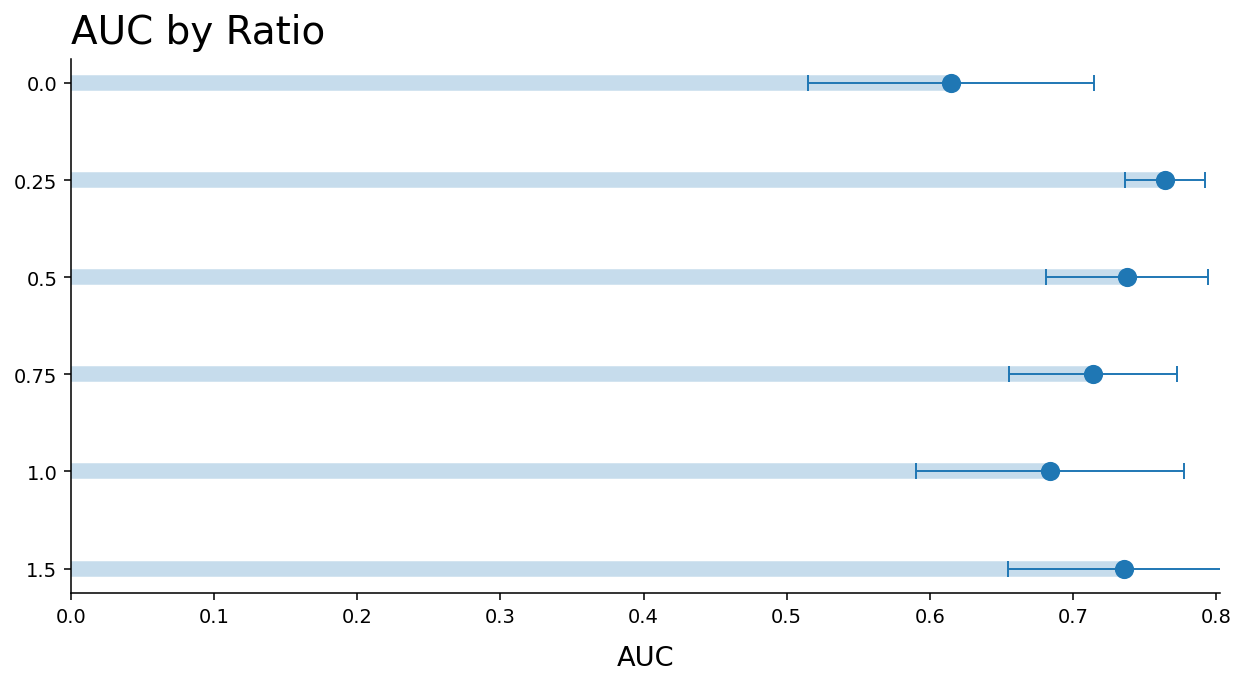

Saved: auc_by_ratio_lollipop.png | error=std


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _bootstrap_ci_mean(a, iters=2000, alpha=0.05, rng=None):
    rng = rng or np.random.default_rng(123)
    a = np.asarray(a, dtype=float)
    a = a[~np.isnan(a)]
    if len(a) == 0:
        return np.nan, np.nan
    means = [rng.choice(a, size=len(a), replace=True).mean() for _ in range(iters)]
    lo = np.percentile(means, 100*alpha/2)
    hi = np.percentile(means, 100*(1 - alpha/2))
    return float(lo), float(hi)

def plot_auc_lollipop_by_ratio(df_all, col_ratio="ratio", col_auc="auc",
                               error=None, title="AUC by Ratio",
                               xlabel="AUC", fname="auc_by_ratio_lollipop.png"):
    # 1) filtrar ratios numéricos e ordenar
    tmp = df_all.copy()
    tmp["_ratio_num"] = pd.to_numeric(tmp[col_ratio], errors="coerce")
    tmp = tmp.dropna(subset=["_ratio_num"])
    ratios_sorted = sorted(tmp["_ratio_num"].unique())
    y = np.arange(len(ratios_sorted))

    # 2) agregar por ratio
    means, errs = [], []
    for r in ratios_sorted:
        vals = tmp.loc[tmp["_ratio_num"] == r, col_auc].astype(float).dropna().values
        m = float(np.mean(vals)) if len(vals) else np.nan
        means.append(m)
        if error == "std":
            e = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
        elif error == "ci":
            lo, hi = _bootstrap_ci_mean(vals)
            e = (hi - lo) / 2.0
        else:
            e = 0.0
        errs.append(e)

    # 3) figura
    fig, ax = plt.subplots(figsize=(9, 5), dpi=140)

    # linhas horizontais (barras suaves)
    for yi, m in zip(y, means):
        ax.hlines(y=yi, xmin=0, xmax=m, linewidth=8, alpha=0.25)

    # pontos no final
    ax.scatter(means, y, s=70, linewidths=1.5)

    # erro opcional
    if error is not None:
        ax.errorbar(means, y, xerr=errs, fmt="none", capsize=4, linewidth=1)

    # eixos e estética
    ax.set_yticks(y)
    ax.set_yticklabels([str(r) for r in ratios_sorted])
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=20, loc="left", pad=8)

    # sem grid vertical nem horizontal
    ax.grid(False)

    # remover spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # inverter eixo y (0 no topo)
    ax.invert_yaxis()

    # margem à direita
    xmax = np.nanmax(means)
    ax.set_xlim(left=0, right=xmax * 1.05)

    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    print(f"Saved: {fname} | error={error}")

# Exemplo de uso:
plot_auc_lollipop_by_ratio(df_all, error="std")
# plot_auc_lollipop_by_ratio(df_all, error=None)


# Rodando várias vezes (Balanceado)

In [68]:
import numpy as np
import pandas as pd
import torch
import time
import os, random

def _seed_everything(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def run_k_times_balance(
    k: int,
    train_dataset,
    test_dataset,
    make_generator0_fn,   # -> G_class0 (nn.Module)
    latent_dim: int,
    step_ratio: float = 0.25,
    batch_size: int = 64,
    epochs: int = 5,
    device: str | None = None
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    all_runs = []
    elapsed_times = []  # <-- novo

    print(f"\n=== Iniciando {k} rodadas (BALANCEADO classe 0) ===")
    start_global = time.time()

    for run_id in range(1, k + 1):
        run_start = time.time()
        print("\n" + "="*70)
        print(f"== Rodada {run_id}/{k}")
        print("="*70)

        # 1) Treinar/carregar gerador da classe 0 desta rodada
        G_class0 = make_generator0_fn(run_id)

        # 2) Executar experimento balanceado
        df_k = balance_class0_experiment(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            G_class0=G_class0,
            latent_dim=latent_dim,
            step_ratio=step_ratio,
            epochs=epochs,
            batch_size=batch_size,
            device=device
        )
        df_k["run_id"] = run_id
        all_runs.append(df_k)

        # liberar memória
        del G_class0
        if device == 'cuda':
            torch.cuda.empty_cache()

        # 3) Tempos/estimativas (corrigido)
        elapsed = time.time() - run_start
        elapsed_times.append(elapsed)
        avg_time = float(np.mean(elapsed_times))
        remaining = avg_time * (k - run_id)
        print(f"⏱️  Tempo da rodada {run_id}: {elapsed/60:.2f} min")
        print(f"🕐  Estimativa restante: {remaining/60:.2f} min ({(remaining/3600):.2f} h)")

    total_time = time.time() - start_global
    print("\n" + "="*70)
    print(f"✅ Todas as {k} rodadas (balanceado) concluídas.")
    print(f"⏱️  Tempo total: {total_time/60:.2f} min ({(total_time/3600):.2f} h)")
    print("="*70 + "\n")

    # 4) Concatena e agrega média/desvio por ratio
    df_all = pd.concat(all_runs, ignore_index=True)
    metrics_cols = ["acc","prec","rec","f1","auc","tn","fp","fn","tp",
                    "added_class0_synth_total","added_this_round"]
    agg = df_all.groupby("ratio").agg({m:["mean","std"] for m in metrics_cols if m in df_all.columns}).reset_index()
    agg.columns = ['_'.join(col).strip('_') for col in agg.columns.values]

    return df_all, agg


In [69]:
def make_generator0_fn_factory(train_loader, latent_dim: int, gan_epochs: int = 50, device: str | None = None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    def make_generator0_fn(run_id: int):
        seed = 2000 + run_id
        print(f"[GAN-0] Rodada {run_id}: treinando G_class0 do zero | seed={seed}")
        _seed_everything(seed)

        G0 = DCGenerator(latent_dim=latent_dim).to(device)
        D0 = DCDiscriminator(img_channels=1).to(device)
        G0 = train_gan_for_class(
            train_loader=train_loader,
            label_target=0,
            G=G0, D=D0,
            latent_dim=latent_dim,
            num_epochs=gan_epochs,
            device=device
        ).eval()
        return G0

    return make_generator0_fn


In [70]:
make_generator0_fn = make_generator0_fn_factory(
    train_loader=train_loader,
    latent_dim=latent_dim,
    gan_epochs=50,
    device=None
)

df_all_bal, df_summary_bal = run_k_times_balance(
    k=5,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    make_generator0_fn=make_generator0_fn,  # << só classe 0
    latent_dim=latent_dim,
    step_ratio=0.25,
    batch_size=64,
    epochs=5,
    device=None
)

print("\n=== resumo (média e desvio por ratio) — BALANCEADO ===")
print(df_summary_bal)



=== Iniciando 5 rodadas (BALANCEADO classe 0) ===

== Rodada 1/5
[GAN-0] Rodada 1: treinando G_class0 do zero | seed=2001
Epoch 1/50 - Loss D: 0.945 | Loss G: 1.159
Epoch 2/50 - Loss D: 0.403 | Loss G: 1.932
Epoch 3/50 - Loss D: 0.256 | Loss G: 2.407
Epoch 4/50 - Loss D: 0.172 | Loss G: 2.752
Epoch 5/50 - Loss D: 0.163 | Loss G: 2.913
Epoch 6/50 - Loss D: 0.152 | Loss G: 3.158
Epoch 7/50 - Loss D: 0.124 | Loss G: 3.176
Epoch 8/50 - Loss D: 0.190 | Loss G: 3.060
Epoch 9/50 - Loss D: 0.167 | Loss G: 3.088
Epoch 10/50 - Loss D: 0.158 | Loss G: 3.241
Epoch 11/50 - Loss D: 0.193 | Loss G: 3.328
Epoch 12/50 - Loss D: 0.197 | Loss G: 3.321
Epoch 13/50 - Loss D: 0.344 | Loss G: 2.879
Epoch 14/50 - Loss D: 0.246 | Loss G: 3.048
Epoch 15/50 - Loss D: 0.214 | Loss G: 2.746
Epoch 16/50 - Loss D: 0.642 | Loss G: 3.189
Epoch 17/50 - Loss D: 0.336 | Loss G: 2.538
Epoch 18/50 - Loss D: 0.356 | Loss G: 2.555
Epoch 19/50 - Loss D: 0.496 | Loss G: 2.349
Epoch 20/50 - Loss D: 0.384 | Loss G: 2.223
Epoch 

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.25: +315 (classe 0; sendo 252 p/ balancear + 63 extra) → total sintético classe0=315


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.50: +378 (classe 0; sendo 252 p/ balancear + 126 extra) → total sintético classe0=378


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.75: +441 (classe 0; sendo 252 p/ balancear + 189 extra) → total sintético classe0=441


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=1.00: +504 (classe 0; sendo 252 p/ balancear + 252 extra) → total sintético classe0=504


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


⏱️  Tempo da rodada 1: 0.79 min
🕐  Estimativa restante: 3.16 min (0.05 h)

== Rodada 2/5
[GAN-0] Rodada 2: treinando G_class0 do zero | seed=2002
Epoch 1/50 - Loss D: 1.008 | Loss G: 1.087
Epoch 2/50 - Loss D: 0.430 | Loss G: 1.939
Epoch 3/50 - Loss D: 0.264 | Loss G: 2.267
Epoch 4/50 - Loss D: 0.277 | Loss G: 2.338
Epoch 5/50 - Loss D: 0.236 | Loss G: 2.655
Epoch 6/50 - Loss D: 0.127 | Loss G: 3.215
Epoch 7/50 - Loss D: 0.089 | Loss G: 3.532
Epoch 8/50 - Loss D: 0.064 | Loss G: 3.773
Epoch 9/50 - Loss D: 0.050 | Loss G: 4.066
Epoch 10/50 - Loss D: 0.067 | Loss G: 3.754
Epoch 11/50 - Loss D: 0.171 | Loss G: 3.483
Epoch 12/50 - Loss D: 0.135 | Loss G: 3.186
Epoch 13/50 - Loss D: 0.145 | Loss G: 3.214
Epoch 14/50 - Loss D: 0.225 | Loss G: 2.908
Epoch 15/50 - Loss D: 0.338 | Loss G: 3.116
Epoch 16/50 - Loss D: 0.234 | Loss G: 3.149
Epoch 17/50 - Loss D: 0.177 | Loss G: 3.274
Epoch 18/50 - Loss D: 0.181 | Loss G: 3.392
Epoch 19/50 - Loss D: 0.171 | Loss G: 3.189
Epoch 20/50 - Loss D: 0.188

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.25: +315 (classe 0; sendo 252 p/ balancear + 63 extra) → total sintético classe0=315


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.50: +378 (classe 0; sendo 252 p/ balancear + 126 extra) → total sintético classe0=378


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.75: +441 (classe 0; sendo 252 p/ balancear + 189 extra) → total sintético classe0=441


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=1.00: +504 (classe 0; sendo 252 p/ balancear + 252 extra) → total sintético classe0=504


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


⏱️  Tempo da rodada 2: 0.79 min
🕐  Estimativa restante: 2.37 min (0.04 h)

== Rodada 3/5
[GAN-0] Rodada 3: treinando G_class0 do zero | seed=2003
Epoch 1/50 - Loss D: 1.010 | Loss G: 1.051
Epoch 2/50 - Loss D: 0.515 | Loss G: 1.652
Epoch 3/50 - Loss D: 0.357 | Loss G: 2.030
Epoch 4/50 - Loss D: 0.242 | Loss G: 2.437
Epoch 5/50 - Loss D: 0.239 | Loss G: 2.434
Epoch 6/50 - Loss D: 0.249 | Loss G: 2.665
Epoch 7/50 - Loss D: 0.183 | Loss G: 2.863
Epoch 8/50 - Loss D: 0.146 | Loss G: 3.012
Epoch 9/50 - Loss D: 0.153 | Loss G: 3.025
Epoch 10/50 - Loss D: 0.149 | Loss G: 3.083
Epoch 11/50 - Loss D: 0.151 | Loss G: 3.258
Epoch 12/50 - Loss D: 0.181 | Loss G: 3.012
Epoch 13/50 - Loss D: 0.185 | Loss G: 3.127
Epoch 14/50 - Loss D: 0.596 | Loss G: 2.418
Epoch 15/50 - Loss D: 0.430 | Loss G: 2.267
Epoch 16/50 - Loss D: 0.353 | Loss G: 2.177
Epoch 17/50 - Loss D: 0.594 | Loss G: 2.584
Epoch 18/50 - Loss D: 0.399 | Loss G: 2.373
Epoch 19/50 - Loss D: 0.385 | Loss G: 2.322
Epoch 20/50 - Loss D: 1.019

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.25: +315 (classe 0; sendo 252 p/ balancear + 63 extra) → total sintético classe0=315


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.50: +378 (classe 0; sendo 252 p/ balancear + 126 extra) → total sintético classe0=378


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.75: +441 (classe 0; sendo 252 p/ balancear + 189 extra) → total sintético classe0=441


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=1.00: +504 (classe 0; sendo 252 p/ balancear + 252 extra) → total sintético classe0=504


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


⏱️  Tempo da rodada 3: 0.77 min
🕐  Estimativa restante: 1.57 min (0.03 h)

== Rodada 4/5
[GAN-0] Rodada 4: treinando G_class0 do zero | seed=2004
Epoch 1/50 - Loss D: 0.894 | Loss G: 1.132
Epoch 2/50 - Loss D: 0.517 | Loss G: 1.740
Epoch 3/50 - Loss D: 0.377 | Loss G: 2.066
Epoch 4/50 - Loss D: 0.293 | Loss G: 2.264
Epoch 5/50 - Loss D: 0.255 | Loss G: 2.420
Epoch 6/50 - Loss D: 0.212 | Loss G: 2.645
Epoch 7/50 - Loss D: 0.188 | Loss G: 2.828
Epoch 8/50 - Loss D: 0.168 | Loss G: 3.027
Epoch 9/50 - Loss D: 0.169 | Loss G: 3.036
Epoch 10/50 - Loss D: 0.245 | Loss G: 3.092
Epoch 11/50 - Loss D: 0.188 | Loss G: 3.102
Epoch 12/50 - Loss D: 0.176 | Loss G: 3.008
Epoch 13/50 - Loss D: 0.220 | Loss G: 3.010
Epoch 14/50 - Loss D: 0.194 | Loss G: 3.275
Epoch 15/50 - Loss D: 0.246 | Loss G: 3.072
Epoch 16/50 - Loss D: 0.612 | Loss G: 2.776
Epoch 17/50 - Loss D: 0.463 | Loss G: 2.626
Epoch 18/50 - Loss D: 0.337 | Loss G: 2.565
Epoch 19/50 - Loss D: 0.353 | Loss G: 2.429
Epoch 20/50 - Loss D: 0.354

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.25: +315 (classe 0; sendo 252 p/ balancear + 63 extra) → total sintético classe0=315


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.50: +378 (classe 0; sendo 252 p/ balancear + 126 extra) → total sintético classe0=378


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.75: +441 (classe 0; sendo 252 p/ balancear + 189 extra) → total sintético classe0=441


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=1.00: +504 (classe 0; sendo 252 p/ balancear + 252 extra) → total sintético classe0=504


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


⏱️  Tempo da rodada 4: 0.79 min
🕐  Estimativa restante: 0.79 min (0.01 h)

== Rodada 5/5
[GAN-0] Rodada 5: treinando G_class0 do zero | seed=2005
Epoch 1/50 - Loss D: 0.900 | Loss G: 1.292
Epoch 2/50 - Loss D: 0.330 | Loss G: 2.139
Epoch 3/50 - Loss D: 0.182 | Loss G: 2.681
Epoch 4/50 - Loss D: 0.141 | Loss G: 2.905
Epoch 5/50 - Loss D: 0.103 | Loss G: 3.213
Epoch 6/50 - Loss D: 0.076 | Loss G: 3.579
Epoch 7/50 - Loss D: 0.050 | Loss G: 3.917
Epoch 8/50 - Loss D: 0.094 | Loss G: 3.641
Epoch 9/50 - Loss D: 0.098 | Loss G: 3.724
Epoch 10/50 - Loss D: 0.064 | Loss G: 3.875
Epoch 11/50 - Loss D: 0.153 | Loss G: 4.125
Epoch 12/50 - Loss D: 0.053 | Loss G: 4.300
Epoch 13/50 - Loss D: 0.038 | Loss G: 4.538
Epoch 14/50 - Loss D: 0.025 | Loss G: 4.632
Epoch 15/50 - Loss D: 0.019 | Loss G: 5.013
Epoch 16/50 - Loss D: 0.013 | Loss G: 5.385
Epoch 17/50 - Loss D: 0.012 | Loss G: 5.500
Epoch 18/50 - Loss D: 0.011 | Loss G: 5.476
Epoch 19/50 - Loss D: 0.010 | Loss G: 5.544
Epoch 20/50 - Loss D: 0.009

/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.25: +315 (classe 0; sendo 252 p/ balancear + 63 extra) → total sintético classe0=315


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.50: +378 (classe 0; sendo 252 p/ balancear + 126 extra) → total sintético classe0=378


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=0.75: +441 (classe 0; sendo 252 p/ balancear + 189 extra) → total sintético classe0=441


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


ratio=1.00: +504 (classe 0; sendo 252 p/ balancear + 252 extra) → total sintético classe0=504


/tmp/ipykernel_1197133/271428978.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)


⏱️  Tempo da rodada 5: 0.79 min
🕐  Estimativa restante: 0.00 min (0.00 h)

✅ Todas as 5 rodadas (balanceado) concluídas.
⏱️  Tempo total: 3.94 min (0.07 h)


=== resumo (média e desvio por ratio) — BALANCEADO ===
   ratio  acc_mean   acc_std  prec_mean  prec_std  rec_mean   rec_std  \
0   0.00  0.833333  0.023553   0.883815  0.020721  0.889474  0.033171   
1   0.25  0.825641  0.024156   0.853149  0.038576  0.922807  0.020003   
2   0.50  0.835897  0.021066   0.874571  0.030238  0.908772  0.068117   
3   0.75  0.793590  0.042376   0.889643  0.035721  0.824561  0.103976   
4   1.00  0.791026  0.025074   0.861813  0.077858  0.868421  0.110436   

    f1_mean    f1_std  auc_mean  ...  fp_mean     fp_std  fn_mean     fn_std  \
0  0.886220  0.017046  0.785213  ...     13.4   2.880972     12.6   3.781534   
1  0.885836  0.012141  0.742356  ...     18.4   5.899152      8.8   2.280351   
2  0.889212  0.020520  0.773434  ...     15.2   4.969909     10.4   7.765307   
3  0.851231  0.042561  0.767

In [72]:
df_summary_bal

,ratio,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std,auc_mean,...,fp_mean,fp_std,fn_mean,fn_std,tp_mean,tp_std,added_class0_synth_total_mean,added_class0_synth_total_std,added_this_round_mean,added_this_round_std
0,0.00,0.833333,0.023553,0.883815,0.020721,0.889474,0.033171,0.886220,0.017046,0.785213,...,13.4,2.880972,12.6,3.781534,101.4,3.781534,252.0,0.0,252.0,0.0
1,0.25,0.825641,0.024156,0.853149,0.038576,0.922807,0.020003,0.885836,0.012141,0.742356,...,18.4,5.899152,8.8,2.280351,105.2,2.280351,315.0,0.0,315.0,0.0
2,0.50,0.835897,0.021066,0.874571,0.030238,0.908772,0.068117,0.889212,0.020520,0.773434,...,15.2,4.969909,10.4,7.765307,103.6,7.765307,378.0,0.0,378.0,0.0
3,0.75,0.793590,0.042376,0.889643,0.035721,0.824561,0.103976,0.851231,0.042561,0.767043,...,12.2,5.848077,20.0,11.853270,94.0,11.853270,441.0,0.0,441.0,0.0
4,1.00,0.791026,0.025074,0.861813,0.077858,0.868421,0.110436,0.856978,0.026879,0.724687,...,17.6,11.886968,15.0,12.589678,99.0,12.589678,504.0,0.0,504.0,0.0


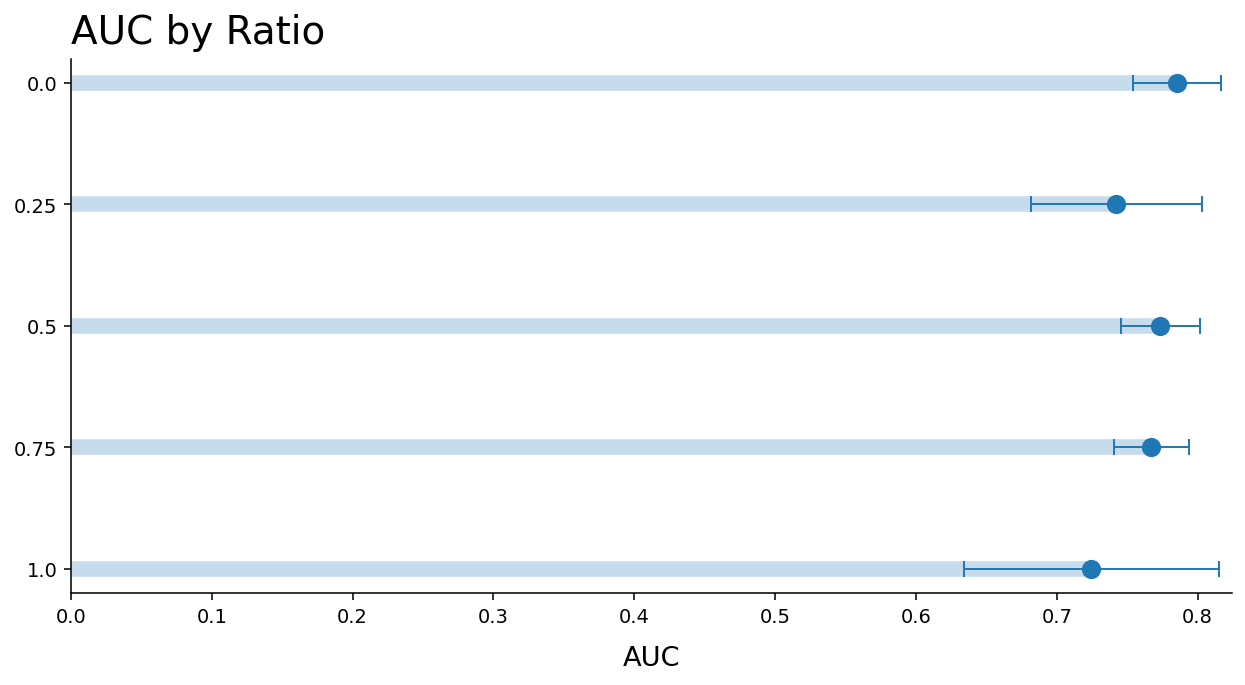

Saved: auc_by_ratio_lollipop.png | error=std


In [79]:
plot_auc_lollipop_by_ratio(df_all_bal, error="std")
